◼ **Classificação das doenças nas plantas V2**

◼ **Importando módulos**

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from zipfile import ZipFile
import splitfolders

◼ **Caminho das imagens**

In [3]:
root_path= os.path.join("data/newplantsvillage.zip")

◼ **Extrair as imagens do arquivo .zip**

In [4]:
with ZipFile(root_path, 'r') as zipObj:
  zipObj.extractall()
  print('Done')

Done


◼ **Criar uma lista das classes**

In [5]:
classes_train = sorted(list(filter(lambda x: os.path.isdir('newplantsvillage/' + x), os.listdir('newplantsvillage'))))


◼ **Exibir os nomes de todas as classes**

In [6]:
print(classes_train)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

◼ **Parâmetros de funções callback**

In [9]:
batch_size = 32
learning_rate = 0.001
epochs = 12

◼ **Dividir as classes em treino e validação**

In [15]:
input_folder='newplantsvillage'
splitfolders.ratio(input_folder, output="output_newplantsvillage", seed=1337, ratio=(.8,.2))

◼ **Gerar novas Imagens**

- ImageDataGenerator é uma classe da biblioteca Keras do TensorFlow que permite gerar automaticamente novas imagens com base em um conjunto de imagens existentes.

train_datagen:
- Cria um objeto redimensionando os valores dos pixels das imagens para o intervalo entre 0 e 1

train_generator:
- Dados de treinamento

val_generator:
- Dados de validação

**Importante**
- Esses geradores de dados são utilizados para fornecer lotes de imagens e seus rótulos associados durante o treinamento e a validação do modelo de rede neural. O uso de geradores é útil para lidar com conjuntos de dados grandes, pois permite carregar e processar os dados em lotes, economizando memória e facilitando o treinamento em lotes da rede neural.

In [16]:
train_datagen=ImageDataGenerator(rescale=1/255)
train_generator=train_datagen.flow_from_directory(
    'output_newplantsvillage/train',
    target_size=(200, 200),
    batch_size=batch_size,
    classes = classes_train,
    class_mode='categorical'
)
val_datagen=ImageDataGenerator(rescale=1/255)
val_generator=val_datagen.flow_from_directory(
    'output_newplantsvillage/val',
    target_size=(200, 200),
    batch_size=batch_size,
    classes = classes_train,
    class_mode='categorical'
)

Found 43429 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.


◼ **Transfer learning**

Cria um modelo DenseNet121 com pesos pré-treinados do ImageNet e configura todas as camadas como treináveis para que possam ser ajustadas durante o treinamento com os dados específicos do problema. Importante: include_top=False: Indica que a camada de classificação final (top layer) do DenseNet121 não será incluída no modelo. Isso é útil quando queremos substituir a camada de classificação original por uma nova camada personalizada.

In [17]:
d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers[:149]:
  i.trainable = False

for i in d.layers[149:]:
  i.trainable = True

##### Novo modelo é construído adicionando camadas personalizadas ao modelo DenseNet121 existente.

#### Passo a passo:

- Uma camada de pooling global médio é adicionada ao final do modelo DenseNet121 para reduzir a dimensionalidade do tensor de saída para calcular a média de cada canal ao longo de todas as posições espaciais da saída.
- Uma camada de pooling global máximo é adicionada ao final do modelo DenseNet121 para calcular o valor máximo de cada canal ao longo de todas as posições espaciais da saída.
- Mais uma camada que calcula o valor mínimo elemento a elemento entre os tensores de saída do pooling médio global e do pooling máximo global. Isso ajuda a capturar informações diferentes e complementares dos dois tipos de pooling.
- Uma camada de dropout é adicionada para ajudar a reduzir o overfitting, desligando aleatoriamente 50% dos neurônios de entrada durante o treinamento.
- Uma camada densa com 128 neurônios é adicionada, seguida pela função de ativação sigmoid.
- Mais um dropout é adicionado com uma taxa de 30%.
- A camada de saída final é uma camada densa com 4 neurônios (correspondendo aos 4 rótulos possíveis) usando a função de ativação softmax para obter probabilidades de classe.
- O modelo é compilado com o otimizador Adam, função de perda de entropia cruzada e as métricas de avaliação usadas são de precisão e recall.

In [24]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(38, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)

◼ **Compilação do modelo neural**

In [25]:
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])

**Determinar o número de etapas a serem executadas durante o treinamento e validação do modelo**

steps_per_epoch:

- train_generator.n = Número total de amostras no conjunto de treinamento.
- train_generator.batch_size = Tamanho do lote (batch size) usado durante o treinamento.

A divisão train_generator.n // train_generator.batch_size calcula o número de lotes (batches) completos que podem ser formados a partir do conjunto de treinamento. Isso define o número de etapas (steps) a serem executadas durante cada época (epoch) de treinamento. Cada etapa envolve a passagem de um lote (batch) de dados pelo modelo para atualização dos pesos.


validation_steps:
- val_generator.n: Número total de amostras no conjunto de validação.
- val_generator.batch_size: Tamanho do lote (batch size) usado durante a validação.


A divisão val_generator.n // val_generator.batch_size calcula o número de lotes (batches) completos que podem ser formados a partir do conjunto de validação. Isso define o número de etapas (steps) a serem executadas durante a validação.

In [26]:
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=val_generator.n//val_generator.batch_size

◼ **Funções callbacks**
- EarlyStopping
- ModelCheckpoint
- ReduceLROnPlateau

In [22]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "save_points/pcd_v2.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

reducelr =  keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2, mode='min',
    patience=2
)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=3,
    min_delta=0.001,
    mode='max',
    restore_best_weights=True
)

◼ **Treinar o modelo**

**Importante**

Uma lista de objetos de callback podem ser são usados durante o treinamento para realizar ações específicas:
- (ReduceLROnPlateau) - Ajustar a taxa de aprendizado
- (EarlyStopping) - Parar o treinamento antecipadamente se a perda não estiver melhorando (EarlyStopping)
- (ModelCheckpoint) - Salvar o modelo (em um arquivo de ponto de verificação) em algum intervalo, para que o modelo possa ser carregado posteriormente para continuar o treinamento do estado salvo.

In [27]:
history = m.fit(
    x=train_generator,
    y=None,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[
        earlystopping,
        checkpoint,
        reducelr
    ]
)

Epoch 1/12
1357/1357 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.8004 - precision: 0.9021 - recall: 0.7400
Epoch 1: val_loss improved from inf to 0.14426, saving model to save_points\pcd_v2.h5
1357/1357 [==============================] - 3961s 3s/step - loss: 0.6712 - accuracy: 0.8004 - precision: 0.9021 - recall: 0.7400 - val_loss: 0.1443 - val_accuracy: 0.9562 - val_precision: 0.9616 - val_recall: 0.9509 - lr: 0.0010
Epoch 2/12
1357/1357 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9358 - precision: 0.9490 - recall: 0.9243
Epoch 2: val_loss improved from 0.14426 to 0.11360, saving model to save_points\pcd_v2.h5
1357/1357 [==============================] - 4123s 3s/step - loss: 0.2124 - accuracy: 0.9358 - precision: 0.9490 - recall: 0.9243 - val_loss: 0.1136 - val_accuracy: 0.9690 - val_precision: 0.9733 - val_recall: 0.9651 - lr: 0.0010
Epoch 3/12
1357/1357 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9

◼ **Exibibir a performance do modelo**

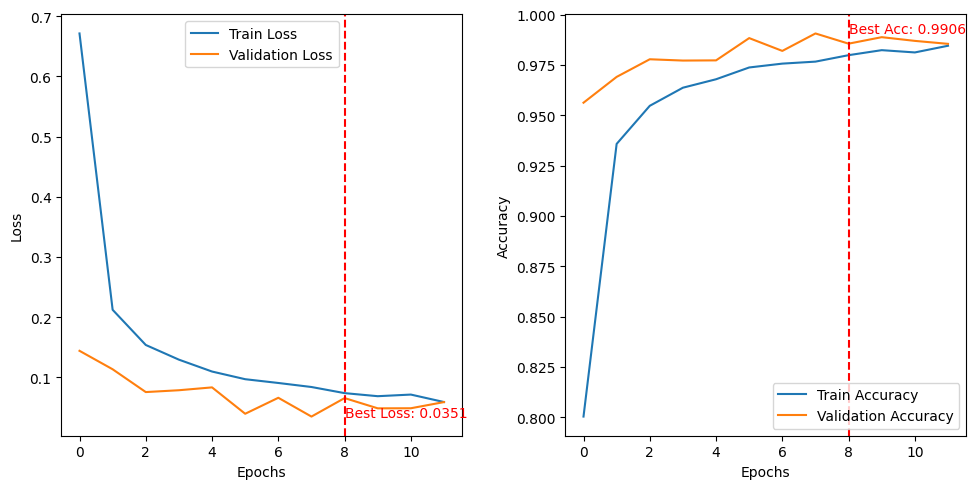

In [28]:
# Obtenha as métricas de treinamento do histórico
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Obtenha as métricas de validação do histórico
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Crie o gráfico
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

best_epoch = np.argmin(val_loss) + 1
best_val_loss = val_loss[best_epoch - 1]
best_val_acc = val_acc[best_epoch - 1]

# Destaque a melhor época no gráfico
plt.subplot(1, 2, 1)
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.text(best_epoch, best_val_loss, f'Best Loss: {best_val_loss:.4f}', color='r')

plt.subplot(1, 2, 2)
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.text(best_epoch, best_val_acc, f'Best Acc: {best_val_acc:.4f}', color='r')

plt.tight_layout()
plt.show()

◼ **Avaliação do desempenho**

- O método evaluate() é usado para avaliar o desempenho de um modelo de rede neural em um conjunto de dados de teste.

In [33]:
model = tf.keras.models.load_model('save_points/pcd_v2.h5')
model.evaluate(val_generator)

340/340 [==============================] - 1060s 3s/step - loss: 0.0350 - accuracy: 0.9906 - precision: 0.9915 - recall: 0.9901


[0.03499763831496239,
 0.9906215667724609,
 0.9915285706520081,
 0.9900698661804199]

◼ **Salvar o modelo**

In [29]:
keras.models.save_model(m, "model_v2.h5")

◼ **Converter modelo para formato do TensorFlow Lite**

In [34]:
## For TFLite model
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()
open('models/model_v2.tflite', 'wb').write(tflite_model)
## For TFLite optimized model
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_opt_model=converter.convert()
open('models/model_opt_v2.tflite', 'wb').write(tflite_opt_model)

INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmpgttvw6yw\assets


INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmpgttvw6yw\assets


INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmphk1tjusr\assets


INFO:tensorflow:Assets written to: C:\Users\rodri\AppData\Local\Temp\tmphk1tjusr\assets


7725040